In [1]:
import pydicom
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as v2
import torch.nn.functional as F
from math import ceil

In [2]:
%%capture
!pip install einops
from einops import rearrange

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
df_train = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv")
df_train_desc = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")
df_train_desc['image_path'] = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/" + df_train_desc['study_id'].astype(str) +"/"+ df_train_desc['series_id'].astype(str) + "/"+ df_train_desc['instance_number'].astype(str) + ".dcm"

In [5]:
df_train_melted = df_train.melt(id_vars=['study_id'], var_name='condition_level', value_name='value')

# Split the 'condition_level' column to extract 'condition' and 'level'
df_train_melted[['conditions', 'level']] = df_train_melted['condition_level'].str.rsplit('_', n=2, expand=True).iloc[:, 1:]
df_train_melted['condition'] = df_train_melted['condition_level'].apply(lambda x: '_'.join(x.split('_')[:-2])).str.replace("_"," ").str.title()
df_train_melted['level'] = df_train_melted['conditions'].str.upper() +"/"+ df_train_melted['level'].str.upper()
# Remove the original 'condition_level' column
df_train_melted = df_train_melted.drop(columns=['condition_level', 'conditions'])

# Rename columns for clarity
df_train_melted = df_train_melted.rename(columns={'value': 'severity'})

In [6]:
df_final = df_train_desc.merge(df_train_melted, on = ["study_id","level","condition"],how = "left")
df_final.head()

,study_id,series_id,instance_number,condition,level,x,y,image_path,severity
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Normal/Mild
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Normal/Mild
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Normal/Mild
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Normal/Mild
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Normal/Mild


In [7]:
df_final.dropna(inplace=True)
df_final['severity'] = df_final['severity'].map({'Normal/Mild': 0, 'Moderate': 1, 'Severe': 2})

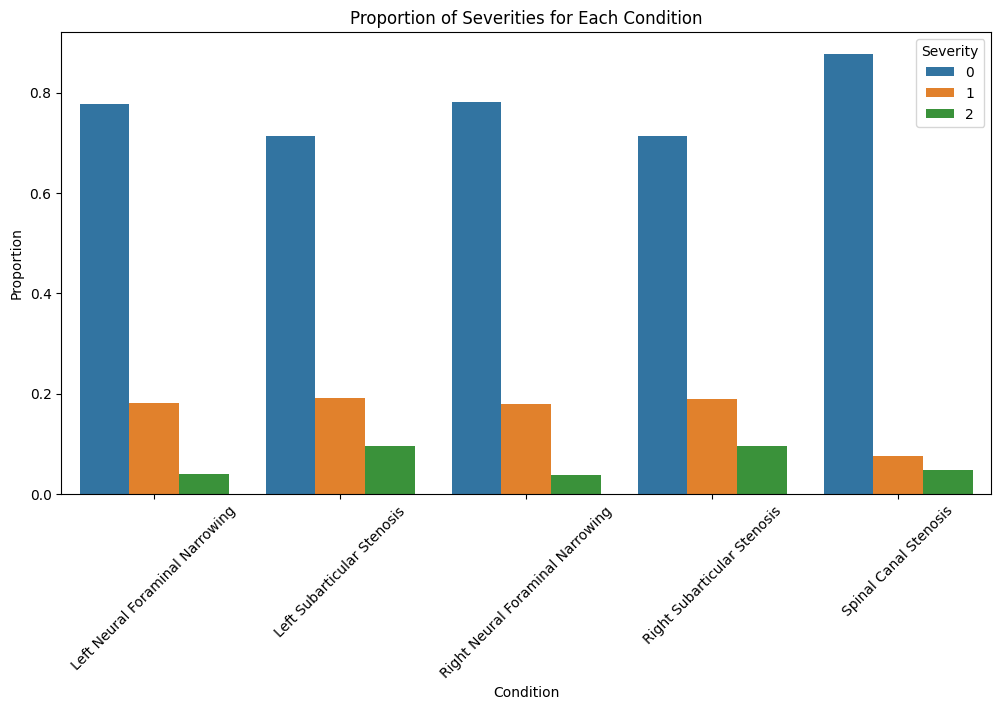

severity,condition,0,1,2
0,Left Neural Foraminal Narrowing,0.777992,0.181744,0.040264
1,Left Subarticular Stenosis,0.714048,0.190982,0.094970
2,Right Neural Foraminal Narrowing,0.781768,0.179774,0.038458
3,Right Subarticular Stenosis,0.713899,0.189867,0.096234
4,Spinal Canal Stenosis,0.876858,0.075054,0.048088


In [8]:
severity_proportions = df_final.groupby('condition')['severity'].value_counts(normalize=True).unstack()

# Reset index to convert the groupby object into a DataFrame
severity_proportions = severity_proportions.reset_index()

# Melt the DataFrame for easier plotting with seaborn
severity_proportions_melted = severity_proportions.melt(id_vars='condition', value_name='proportion')

# Create the count plot
plt.figure(figsize=(12, 6))
sns.barplot(data=severity_proportions_melted, x='condition', y='proportion', hue='severity')
plt.title('Proportion of Severities for Each Condition')
plt.ylabel('Proportion')
plt.xlabel('Condition')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.show()
display(severity_proportions)

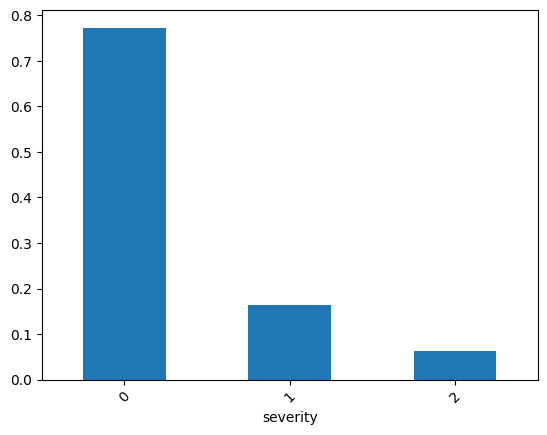

severity
0    37626
1     7950
2     3081
Name: count, dtype: int64

In [9]:
df_final['severity'].value_counts(normalize=True).plot(kind='bar')
plt.xticks(rotation=45)
plt.show()
df_final['severity'].value_counts()

Image shape: (640, 640)
Severity is 0


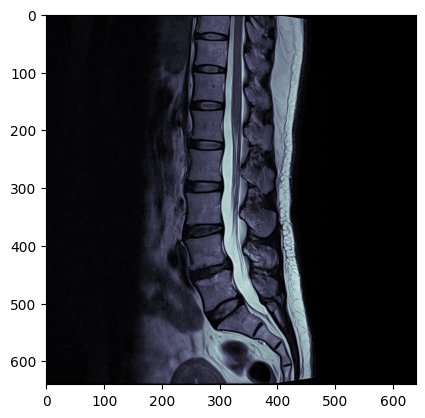

In [10]:
image0 = df_final.iloc[0]['image_path']
ds = pydicom.dcmread(image0)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 
print(f"Image shape: {ds.pixel_array.shape}")
print(f"Severity is {df_final.iloc[0]['severity']}")

In [11]:
"""
        v2.RandomHorizontalFlip(),
        v2.RandomPerspective(),
        v2.RandomRotation((-45, 45)),
        v2.RandomVerticalFlip(),
        v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
        v2.ElasticTransform(alpha=250.0),
        v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        v2.RandomAdjustSharpness(sharpness_factor=2),
        v2.RandomAutocontrast(),
        v2.RandomEqualize(),
        v2.RandomAdjustSharpness(sharpness_factor=2),
        v2.ColorJitter(brightness=.5, hue=.3),
        """

transform = v2.Compose([
        v2.Resize((448, 448), antialias=True),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean = [0.5], std = [0.5])

    ])

class SpineDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['severity']
        image = pydicom.dcmread(image_path)
        image = image.pixel_array.astype(np.float32)
        # image = np.stack([image] * 3, axis=-1)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

# Create dataset and dataloader
dataset = SpineDataset(df_final, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True)

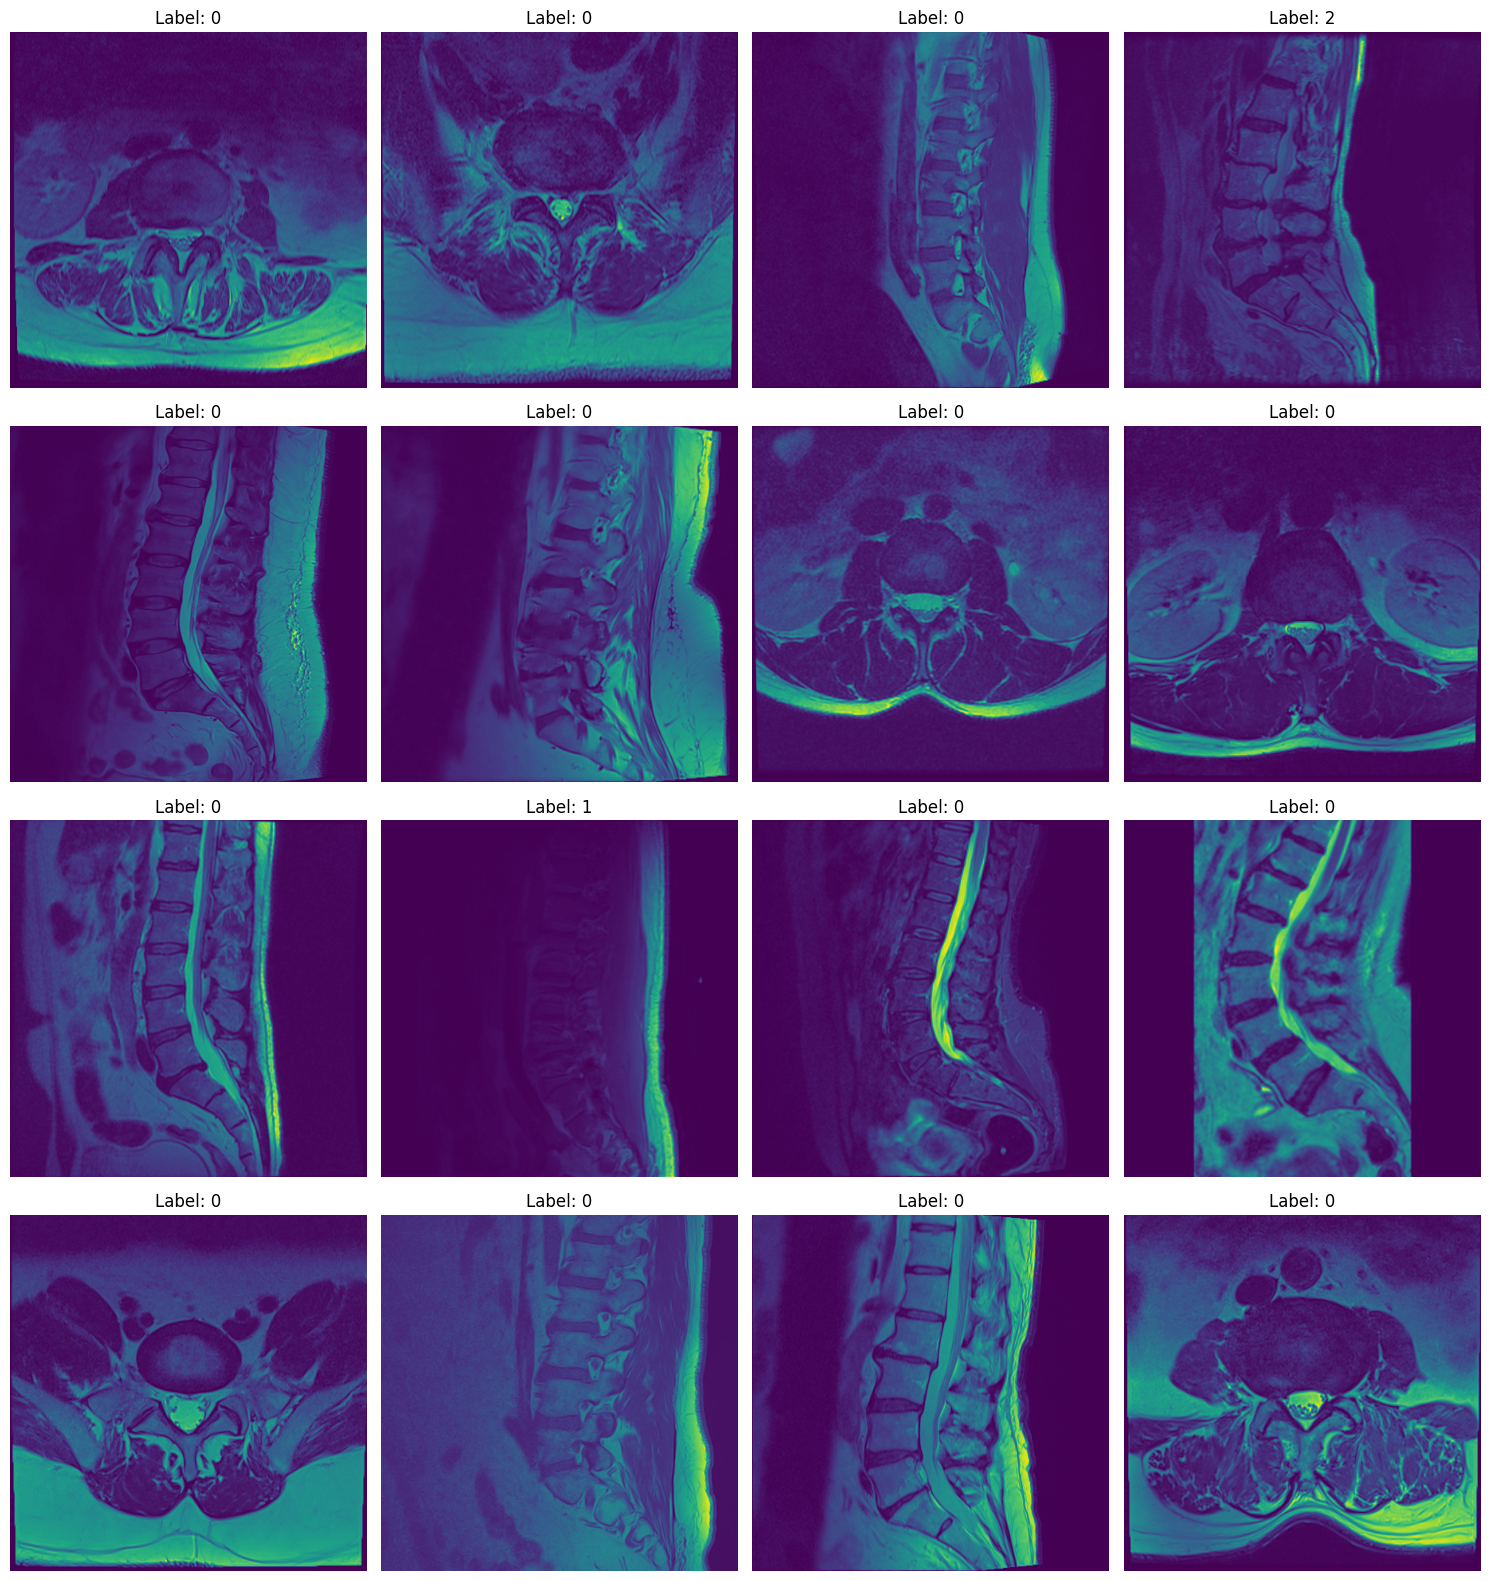

In [12]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Move images to the device
images = images.to(device)

# Set the number of images to plot in a grid
batch_size = images.shape[0]
num_cols = 4
num_rows = (batch_size + num_cols - 1) // num_cols

# Create a figure to hold the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))

# Plot each image
for i in range(batch_size):
    # Select the image and move it to the CPU for plotting
    image = images[i].permute(1, 2, 0).cpu().numpy()

    # Normalize the image to [0, 1] if necessary
    image = (image - image.min()) / (image.max() - image.min())

    # Plot the image
    ax = axs[i // num_cols, i % num_cols]
    ax.imshow(image)
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')

# Remove any empty subplots
for j in range(batch_size, num_rows * num_cols):
    fig.delaxes(axs[j // num_cols, j % num_cols])

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
class Embedding(nn.Module):
    def __init__(self, in_channels, patch_size=4, embed_dim=96):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.linear_embedding = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        b, c, h, w = x.shape
        x = self.linear_embedding(x)
        x = rearrange(x, 'b c (h1) (w1) -> b (h1 w1) c', h1=h//self.patch_size, w1=w//self.patch_size)
        x = self.relu(self.layer_norm(x))
        return x

class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dims, num_heads=4, attn_dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.attn_dropout = attn_dropout
        self.layernorm = nn.LayerNorm([embedding_dims])  # Adjusted normalized_shape
        self.multiheadattention = nn.MultiheadAttention(num_heads=num_heads, embed_dim=embedding_dims, dropout=attn_dropout, batch_first=True)

    def forward(self, x, return_attention_map=False):
        x = self.layernorm(x)
        output, attention_weights = self.multiheadattention(query=x, key=x, value=x, need_weights=True, average_attn_weights=True)
        if return_attention_map:
            return output, attention_weights
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        self.pos_embed = None

    def forward(self, x):
        batch_size, num_patches, embed_dim = x.size()
        if self.pos_embed is None or self.pos_embed.size(1) != num_patches:
            self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim, device=x.device))
        return x + self.pos_embed

class ClassificationToken(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

    def forward(self, x):
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        return torch.cat((cls_tokens, x), dim=1)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadSelfAttentionBlock(embed_dim, num_heads, dropout)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, return_attention_weights=False):
        if return_attention_weights:
            attn_output, attn_weights = self.attention(self.layernorm1(x), return_attention_map=True)
            x = x + attn_output
            x = x + self.mlp(self.layernorm2(x))
            return x, attn_weights
        else:
            x = x + self.attention(self.layernorm1(x))
            x = x + self.mlp(self.layernorm2(x))
            return x

class ClassificationHead(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        cls_token = x[:, 0]  # The first token is the [CLS] token
        return self.fc(cls_token)

class VisionTransformer(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_heads, mlp_dim, num_layers, num_classes):
        super().__init__()
        self.embedding = Embedding(in_channels, patch_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)
        self.cls_token = ClassificationToken(embed_dim)
        self.encoder = nn.ModuleList([TransformerEncoderLayer(embed_dim, num_heads, mlp_dim) for _ in range(num_layers)])
        self.classification_head = ClassificationHead(embed_dim, num_classes)

    def forward(self, x, return_attention_weights=False):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.cls_token(x)

        attn_weights_list = []
        
        for layer in self.encoder:
            if return_attention_weights:
                x, attn_weights = layer(x, return_attention_weights=True)
                attn_weights_list.append(attn_weights)
            else:
                x = layer(x)
        
        x = self.classification_head(x)

        if return_attention_weights:
            return x, attn_weights_list
        else:
            return x

In [14]:
# Model configuration
in_channels = 1
patch_size = 32
embed_dim = 896
num_heads = 14
mlp_dim = 3584
num_layers = 16
num_classes = 3

# Instantiate the model
model = VisionTransformer(
    in_channels=in_channels,
    patch_size=patch_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    num_layers=num_layers,
    num_classes=num_classes
).to(device)

x = torch.randn(2, 1, 448, 448).to(device)
out = model(x)
print(out.shape)

torch.Size([2, 3])


In [15]:
def train(model,
          num_epochs,
          train_loader,
          val_loader,
          lr=1e-4,
          weight_decay=1e-5,
          patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    counter = 0
    best_model_state = None
    best_val_loss = float('inf')
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                           T_max=20,
                                                           eta_min=1e-6,
                                                           last_epoch=-1
                                                           )

    for epoch in range(num_epochs):
        model.train()
        avg_train_loss = []
        for i, (x, y) in enumerate(tqdm(train_loader)):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            avg_train_loss.append(loss.item())
        avg_train_loss = np.mean(avg_train_loss)

        model.eval()
        avg_val_loss = []
        for j, (x, y) in enumerate(tqdm(val_loader)):
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                output = model(x)
                loss = criterion(output, y)
                avg_val_loss.append(loss.item())
        avg_val_loss = np.mean(avg_val_loss)

        if best_val_loss > avg_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break

        tqdm.write(f"Epoch {epoch+1}\nval loss {avg_val_loss}")

        scheduler.step()

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
    df = pd.DataFrame({'train': train_losses, 'val': val_losses})
    plt.plot(df.index+1, df['train'], label='train loss')
    plt.plot(df.index+1, df['val'], label='val loss', linestyle='-.', marker="D")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss over epoch')
    plt.grid(visible=True)
    plt.legend()
    plt.show()

    torch.save(model.state_dict(), 'VitSmall.pth')
    return model, best_val_loss

100%|██████████| 609/609 [06:09<00:00,  1.65it/s]


Epoch 1
val loss 0.6362153855572976


100%|██████████| 609/609 [05:49<00:00,  1.74it/s]


Epoch 2
val loss 0.597776441616182


100%|██████████| 609/609 [05:49<00:00,  1.74it/s]


Epoch 3
val loss 0.5973501608191648


100%|██████████| 609/609 [05:51<00:00,  1.73it/s]


Epoch 4
val loss 0.6525047060671111


100%|██████████| 609/609 [05:50<00:00,  1.74it/s]


Epoch 5
val loss 0.636632725204936


100%|██████████| 609/609 [05:51<00:00,  1.73it/s]


Epoch 6
val loss 0.5791882247417822


100%|██████████| 609/609 [05:57<00:00,  1.70it/s]


Epoch 7
val loss 0.5729762985445987


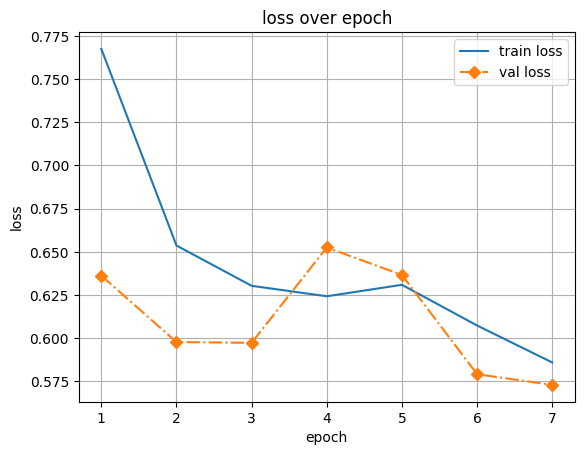

In [16]:
trained_model, best_val_loss = train(model=model.to(device),
          num_epochs=7,
          train_loader=train_loader,
          val_loader=val_loader,
          lr=1e-4,
          weight_decay=1e-5,
          patience=25)